# Libraries

In [1]:
import sys
import pandas as pd
import numpy as np
import warnings
import time
import matplotlib.pyplot as plt

In [2]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [3]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.gaussian_process import GaussianProcessRegressor
from scipy.stats import norm
from scipy.optimize import minimize

# Bayesian Optimizer

In [56]:
class b_optimizer():
      
    def __init__(self, target_func, x_init, y_init, n_iter, scale, batch_size):
        self.x_init = x_init
        self.y_init = y_init
        self.target_func = target_func
        self.n_iter = n_iter
        self.scale = scale
        self.batch_size = batch_size
        self.gauss_pr = GaussianProcessRegressor()
        self.best_samples_ = pd.DataFrame(columns = ['x', 'y', 'ei',"time"])
        self.distances_ = []
        
    def _extend_prior_with_posterior_data(self, x,y):
        self.x_init = np.append(self.x_init, np.array([x]), axis = 0)
        self.y_init = np.append(self.y_init, np.array(y), axis = 0)
        
    def _get_expected_improvement(self, x_new):

        # Using estimate from Gaussian surrogate instead of actual function for a new trial data point to avoid cost 
 
        mean_y_new, sigma_y_new = self.gauss_pr.predict(np.array([x_new]), return_std=True)
        sigma_y_new = sigma_y_new.reshape(-1,1)
        if sigma_y_new == 0.0:
            return 0.0
        
        # Using estimates from Gaussian surrogate instead of actual function for entire prior distribution to avoid cost
        
        mean_y = self.gauss_pr.predict(self.x_init)
        max_mean_y = np.max(mean_y)
        z = (mean_y_new - max_mean_y) / sigma_y_new
        exp_imp = (mean_y_new - max_mean_y) * norm.cdf(z) + sigma_y_new * norm.pdf(z)
        
        return exp_imp
        
    def _acquisition_function(self, x):
        return -self._get_expected_improvement(x)
        
    def _get_next_probable_point(self):
            min_ei = float(sys.maxsize)
            x_optimal = None 
            
            # Trial with an array of random data points
            
            for x_start in (np.random.random((self.batch_size,self.x_init.shape[1])) * self.scale):
                response = minimize(fun=self._acquisition_function, x0=x_start, method='L-BFGS-B')
                if response.fun[0] < min_ei:
                    min_ei = response.fun[0]
                    x_optimal = response.x
            
            return x_optimal, min_ei
    
    def optimize(self):
        y_max_ind = np.argmax(self.y_init)
        y_max = self.y_init[y_max_ind]
        optimal_x = self.x_init[y_max_ind]
        optimal_ei = None
        x_opt = np.array([])
        y_opt = np.array([])
        iter_time = np.array([])
        
        for i in range(self.n_iter):
            self.gauss_pr.fit(self.x_init, self.y_init)
            x_next, ei = self._get_next_probable_point()
            y_next = self.target_func(np.array([x_next]))
            self._extend_prior_with_posterior_data(x_next,y_next)
            
            if i == 0:
                 prev_x = x_next
            
            if y_next[0] > y_max:
                y_max = y_next[0]
                optimal_x = x_next
                optimal_ei = ei[0]

            else:
                self.distances_.append(np.linalg.norm(prev_x - x_next))
                prev_x = x_next
            
            #Store results
            x_opt = np.append(x_opt, optimal_x)
            y_opt = np.append(y_opt, y_max)
        
        # Consolidate results into a dataframe
        data = np.hstack((x_opt.reshape(self.n_iter, 2), y_opt.reshape(-1, 1)))
        results = pd.DataFrame(data)

        return optimal_x, y_max, results

In [5]:
def logisticregression(x):
    total = np.array([])
    for x_i in x:
        c_val = abs(x_i[0])
        penalty_val = x_i[1] 
        if penalty_val > 0.5:
            penalty = "l1"
        else:
            penalty = "l2"
        model = LogisticRegression(fit_intercept=True,
                            multi_class='auto',
                            penalty=penalty, #lasso regression
                            solver='saga',
                            max_iter=1000,
                            C=c_val,
                            verbose=2, # output progress
                            n_jobs=5, # parallelize over 5 processes
                            tol=0.01
                             )
        model.fit(X_train, y_train)
        score = model.score(X_test, y_test)
        total = np.append(total,score)
    return total

In [27]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
warnings.filterwarnings('ignore')
import random

# load the digits dataset
digits = load_digits()

# Train and Test splits
X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target, test_size=0.2, random_state=1)

In [28]:
random.seed(10)
# Initial Values
initial_x = np.array([[1,.1],[10,.9]])
initial_y = logisticregression(initial_x)

[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


convergence after 35 epochs took 0 seconds


[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


convergence after 35 epochs took 0 seconds


[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.2s finished


In [36]:
random.seed(10)
model = b_optimizer(target_func=logisticregression, x_init=initial_x, y_init=initial_y, n_iter=100, scale=100, batch_size=30)
x_max, y_max, df = model.optimize()

[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


convergence after 33 epochs took 0 seconds


[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


convergence after 36 epochs took 0 seconds


[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


convergence after 35 epochs took 0 seconds


[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


convergence after 34 epochs took 1 seconds


[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


convergence after 35 epochs took 0 seconds


[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


convergence after 35 epochs took 1 seconds


[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


convergence after 36 epochs took 0 seconds


[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


convergence after 36 epochs took 1 seconds


[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


convergence after 37 epochs took 0 seconds


[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


convergence after 35 epochs took 0 seconds


[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


convergence after 35 epochs took 1 seconds


[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


convergence after 35 epochs took 0 seconds


[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


convergence after 36 epochs took 1 seconds


[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


convergence after 35 epochs took 0 seconds


[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


convergence after 35 epochs took 0 seconds


[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


convergence after 34 epochs took 1 seconds


[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


convergence after 34 epochs took 0 seconds


[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


convergence after 37 epochs took 1 seconds


[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


convergence after 36 epochs took 0 seconds


[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


convergence after 35 epochs took 0 seconds


[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


convergence after 36 epochs took 1 seconds


[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


convergence after 36 epochs took 0 seconds


[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


convergence after 36 epochs took 0 seconds


[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


convergence after 35 epochs took 0 seconds


[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


convergence after 35 epochs took 0 seconds


[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


convergence after 32 epochs took 1 seconds


[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


convergence after 36 epochs took 0 seconds


[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


convergence after 36 epochs took 0 seconds


[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


convergence after 36 epochs took 0 seconds


[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


convergence after 36 epochs took 0 seconds


[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


convergence after 35 epochs took 1 seconds


[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


convergence after 35 epochs took 0 seconds


[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


convergence after 35 epochs took 0 seconds


[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


convergence after 35 epochs took 0 seconds


[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


convergence after 36 epochs took 0 seconds


[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


convergence after 36 epochs took 1 seconds


[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


convergence after 37 epochs took 0 seconds


[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


convergence after 33 epochs took 0 seconds


[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


convergence after 34 epochs took 0 seconds


[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


convergence after 34 epochs took 0 seconds


[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


convergence after 37 epochs took 1 seconds


[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


convergence after 31 epochs took 0 seconds


[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


convergence after 36 epochs took 0 seconds


[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


convergence after 34 epochs took 1 seconds


[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


convergence after 35 epochs took 0 seconds


[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


convergence after 34 epochs took 1 seconds


[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


convergence after 36 epochs took 0 seconds


[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


convergence after 36 epochs took 0 seconds


[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


convergence after 36 epochs took 1 seconds


[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


convergence after 34 epochs took 0 seconds


[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


convergence after 37 epochs took 1 seconds


[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


convergence after 36 epochs took 0 seconds


[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


convergence after 36 epochs took 1 seconds


[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


convergence after 36 epochs took 0 seconds


[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


convergence after 37 epochs took 0 seconds


[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


convergence after 36 epochs took 0 seconds


[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


convergence after 36 epochs took 0 seconds


[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


convergence after 34 epochs took 0 seconds


[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


convergence after 35 epochs took 0 seconds


[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


convergence after 36 epochs took 1 seconds


[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


convergence after 35 epochs took 0 seconds


[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


convergence after 34 epochs took 0 seconds


[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


convergence after 36 epochs took 0 seconds


[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


convergence after 36 epochs took 0 seconds


[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


convergence after 36 epochs took 0 seconds


[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


convergence after 34 epochs took 1 seconds


[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


convergence after 36 epochs took 0 seconds


[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


convergence after 36 epochs took 0 seconds


[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


convergence after 35 epochs took 0 seconds


[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


convergence after 35 epochs took 0 seconds


[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


convergence after 34 epochs took 0 seconds


[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


convergence after 35 epochs took 0 seconds


[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


convergence after 36 epochs took 0 seconds


[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


convergence after 36 epochs took 0 seconds


[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


convergence after 36 epochs took 1 seconds


[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


convergence after 35 epochs took 0 seconds


[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


convergence after 37 epochs took 1 seconds


[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


convergence after 36 epochs took 0 seconds


[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


convergence after 36 epochs took 1 seconds


[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


convergence after 36 epochs took 0 seconds


[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


convergence after 35 epochs took 1 seconds


[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


convergence after 34 epochs took 0 seconds


[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


convergence after 36 epochs took 1 seconds


[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


convergence after 36 epochs took 1 seconds


[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


convergence after 36 epochs took 0 seconds


[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.4s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


convergence after 36 epochs took 0 seconds


[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


convergence after 35 epochs took 0 seconds


[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


convergence after 35 epochs took 0 seconds


[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


convergence after 35 epochs took 0 seconds


[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


convergence after 35 epochs took 1 seconds


[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


convergence after 35 epochs took 0 seconds


[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


convergence after 35 epochs took 0 seconds


[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


convergence after 37 epochs took 0 seconds


[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


convergence after 34 epochs took 1 seconds


[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


convergence after 36 epochs took 0 seconds


[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


convergence after 35 epochs took 0 seconds


[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


convergence after 36 epochs took 1 seconds


[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


convergence after 35 epochs took 1 seconds


[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


convergence after 34 epochs took 0 seconds


[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


convergence after 35 epochs took 0 seconds


[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.2s finished


In [38]:
# Define Space
space = {
    'C': hp.loguniform('C', -5, 5),
    'penalty': hp.choice('penalty', ['l1', 'l2'])
}

# Define objective function
def objective(params):
    clf = LogisticRegression(C=params['C'], penalty=params['penalty'], solver='liblinear')
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return -accuracy

# Create a Trials object to keep track of the iterations
trials = Trials()

# Run the hyperparameter search using the Tree-structured Parzen Estimator (TPE) algorithm
best = fmin(objective, space, algo=tpe.suggest, max_evals=100, trials=trials)

100%|██████████| 100/100 [00:32<00:00,  3.08trial/s, best loss: -0.9777777777777777]


In [48]:
# Get losses
best = float('inf')  # initialize best to positive infinity
losses = []
for trial in trials.trials:
    loss = trial['result']['loss']
    losses.append(loss)
    if loss < best:
        best = loss
    trial['result']['loss'] = best  # store the minimum value of loss in trial['result']['loss']
iters = [i for i in range(len(losses))]

def Convert(lst):
    return [ -i for i in lst ]
 
# Negate values (accuracy is positive)
accuracy_hyperopt = Convert(losses)

In [ ]:
accuracy = -df.iloc[:,-1]
index = df.index +1

# Accuracy Plot

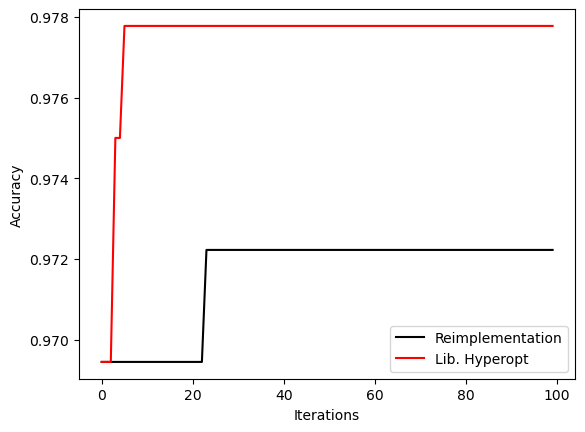

In [49]:
# Plot Results
plt.plot(iters, accuracy, 'black', label='Reimplementation')  
plt.plot(iters, accuracy_hyperopt, 'red', label='Lib. Hyperopt')  
plt.legend()
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.show()

# Costly Function

In [140]:
#Costly Function
def costly_function(x):
    total = np.array([])
    for x_i in x:
        x_i = np.array(x_i)
        total = np.append(total, np.sum(np.exp(-(x_i - 5) ** 2)))
    
    return total + np.random.randn()

In [141]:
sample_x = np.array([[8,1],[6.2,5.3]])
sample_y = costly_function(sample_x)
bopt = b_optimizer(target_func=costly_function, x_init=sample_x, y_init=sample_y, n_iter=100, scale=10, batch_size=30)
x_max, y_max, df = bopt.optimize()

In [151]:
# define the search space
space = {
    'x1': hp.uniform('x1', 0, 10),
    'x2': hp.uniform('x2', 0, 15)
}

# define the objective function to be minimized
def objective(params):
    x = [[params['x1'], params['x2']]]
    loss = -costly_function(x)
    return {'loss': loss[0], 'status': STATUS_OK}

# perform the optimization
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials)
print('Best parameters:', best)

100%|██████████| 100/100 [00:00<00:00, 173.06trial/s, best loss: -3.3290482750612194]
Best parameters: {'x1': 5.737000479248151, 'x2': 7.334316112539555}


In [152]:
best = float('inf')  # initialize best to positive infinity
losses = []
for trial in trials.trials:
    loss = trial['result']['loss']
    if loss < best:
        best = loss
    losses.append(best)
iters = [i for i in range(len(losses))]

In [153]:
accuracy_hyperopt_costly = losses

In [155]:
accuracy = -df.iloc[:,-1]
index = df.index +1

# Minimum Value Plot

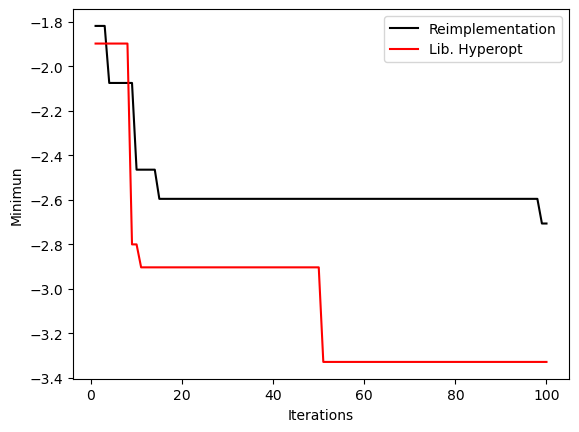

In [158]:
plt.plot(index, accuracy, 'black', label='Reimplementation') 
plt.plot(index, accuracy_hyperopt_costly, 'red', label='Lib. Hyperopt')  
plt.legend()
plt.xlabel('Iterations')
plt.ylabel('Minimun')
plt.show()